# SHAPE DETECTION

In [120]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Problem statement and methodology

**Project Objective:** The aim of our project is to develop a model capable of differentiating between various geometric shapes using a topological data analysis approach.<br>
<br>
**Data Preparation:** In the m_create_pointclouds.py script, we generated 140 point clouds representing seven distinct shapes, ensuring 20 point clouds per shape. The shapes we focused on include spheres, circles, line segments, tori, flat discs, ellipsoids, and perturbed 3-discs. We introduced a degree of randomness to these shapes, altering the positions of their constituent points to simulate natural variations.<br>
<br>
**Methodology:**<br>
<br>
1\)**Standardization:** Our first step involves standardizing the data. We achieve this by confining each shape within a uniformly sized box. Simultaneously, we translate each shape to align its center with the origin (0,0,0). This process ensures that all shapes are comparable in size and positioning.<br>
<br>
2\)**Topological Analysis:**<br>
    Building Rips Complexes: We initiate the analysis by expanding spheres (or balls) around each point in the point clouds, progressively increasing their radii. This method allows us to construct a sequence of Rips complexes, which are fundamental to our topological analysis.
    Persistence Diagrams: From these Rips complexes, we compute persistence diagrams. These diagrams capture the essential topological features of each shape, highlighting their birth and death within the evolving complex.<br>
<br>
3\)**Vectorization of Topological Data:**<br>
    We transform these persistence diagrams into a numerical format suitable for machine learning models. For this, we use persistence images, a technique that effectively vectorizes the topological data.
    To enhance the distinction between shapes that might have similar persistence diagrams (like a line and a rectangle), we create a modified set of shapes. We do this by removing a small open ball from the center of each original shape and recalculating their persistence diagrams and images.<br>
<br>
4\)**Data Integration and Model Training:**<br>
    We combine the vectorized data from both the original and modified shapes, creating a comprehensive feature set for each point cloud.
    Following a train-test split, we employ a Support Vector Machine (SVM) model for classification. The model is optimized and then evaluated on the test set to assess its performance in distinguishing between the various shapes.



# Building our model

File m_create_pointclouds.py includes functions for generation of pointcloud representatations of 7 distinct shapes. We generated 20 instances of each shape and saved them in m_shapes_data.pkl.<br>
File standardize.py includes function for standardization of a pointcloud. Function confines each shape within a uniformly sized box and translates each shape to align its center with the origin (0,0,0). We applied this function to our pointclouds and savet the output in scaled_centered_shapes_data.pkl.<br>
File revome_ball.py includes function that removes a ball with specified radius from the origin (which is now also a center of standardized pointclouds). We use this function on standardized pointclouds and save the output in modified_shape_data.pkl.<br>
File create_PD_and_PI.py includes function for calculating persistence diagrams and images of pointclouds. We apply it to our original standardized shapes and standardized shapes without a ball o points. We save the outputs in flattened_images_with_indices.pkl and flattened_images_removed_ball_with_indices.pkl and later combine them to combined_flattened_data_with_indices.pkl.

We first load the vectorized form of our shapes for SVM model and original shapes for visualization.

In [121]:
# Load the combined flattened images, labels, and original point clouds
with open('Data/m_combined_flattened_data_with_indices.pkl', 'rb') as f_img:
#with open('Data/m_flattened_images_with_indices.pkl', 'rb') as f_img:
    combined_flattened_data = pickle.load(f_img)

# Extracting indices, combined vectors, and labels
indices, combined_vectors, labels = zip(*combined_flattened_data)

# Convert to numpy arrays
combined_vectors = np.array(combined_vectors)
labels = np.array(labels)

# Load the original point clouds for visualization
with open('m_shapes_data.pkl', 'rb') as file:
    original_shape_data = pickle.load(file)

# Extracting indices, combined vectors, and labels
indices2, combined_vectors2, labels2 = zip(*original_shape_data)

We make train test split with stratification.

In [122]:
# Train-test split with stratification
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    combined_vectors, labels, indices, test_size=0.3, random_state=42, stratify=labels
)

Now we train our SVM model. We will try different parameters and evaluate it with cross validation on training set.

In [123]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid: 
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['rbf']  # RBF kernel
}

# Initialize the SVM model
svm_model = SVC()

# Set up GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Retrieve the best model
svm_model = grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...................................C=10, kernel=rbf; total time=   1.0s
[CV] END ...................................C=10, kernel=rbf; total time=   1.1s
[CV] END ....................................C=1, kernel=rbf; total time=   1.5s
[CV] END ....................................C=1, kernel=rbf; total time=   1.6s
[CV] END ....................................C=1, kernel=rbf; total time=   1.7s
[CV] END ....................................C=1, kernel=rbf; total time=   1.8s
[CV] END ....................................C=1, kernel=rbf; total time=   2.0s
[CV] END ...................................C=10, kernel=rbf; total time=   1.3s
[CV] END ...................................C=10, kernel=rbf; total time=   1.3s
[CV] END ...................................C=10, kernel=rbf; total time=   0.9s
[CV] END ..................................C=100, kernel=rbf; total time=   0.9s
[CV] END ..................................C=100,

In [124]:
# # Initialize and train the SVM model
# svm_model = SVC(kernel='rbf')
# svm_model.fit(X_train, y_train)

### Analyzing predictions on test set

In [125]:
def plot_point_cloud(point_cloud, ax, title="Point Cloud"):
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
    ax.set_title(title)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

Now lets check the predictions on test set.

Accuracy: 0.97
Looking for original index: 7
Test Sample 1 - Predicted Class: sphere, Actual Class: sphere
Looking for original index: 31
Test Sample 2 - Predicted Class: circle, Actual Class: circle
Looking for original index: 107
Test Sample 3 - Predicted Class: flat_disc, Actual Class: flat_disc
Looking for original index: 131
Test Sample 4 - Predicted Class: perturbed_3_disc, Actual Class: perturbed_3_disc
Looking for original index: 88
Test Sample 5 - Predicted Class: flat_disc, Actual Class: flat_disc


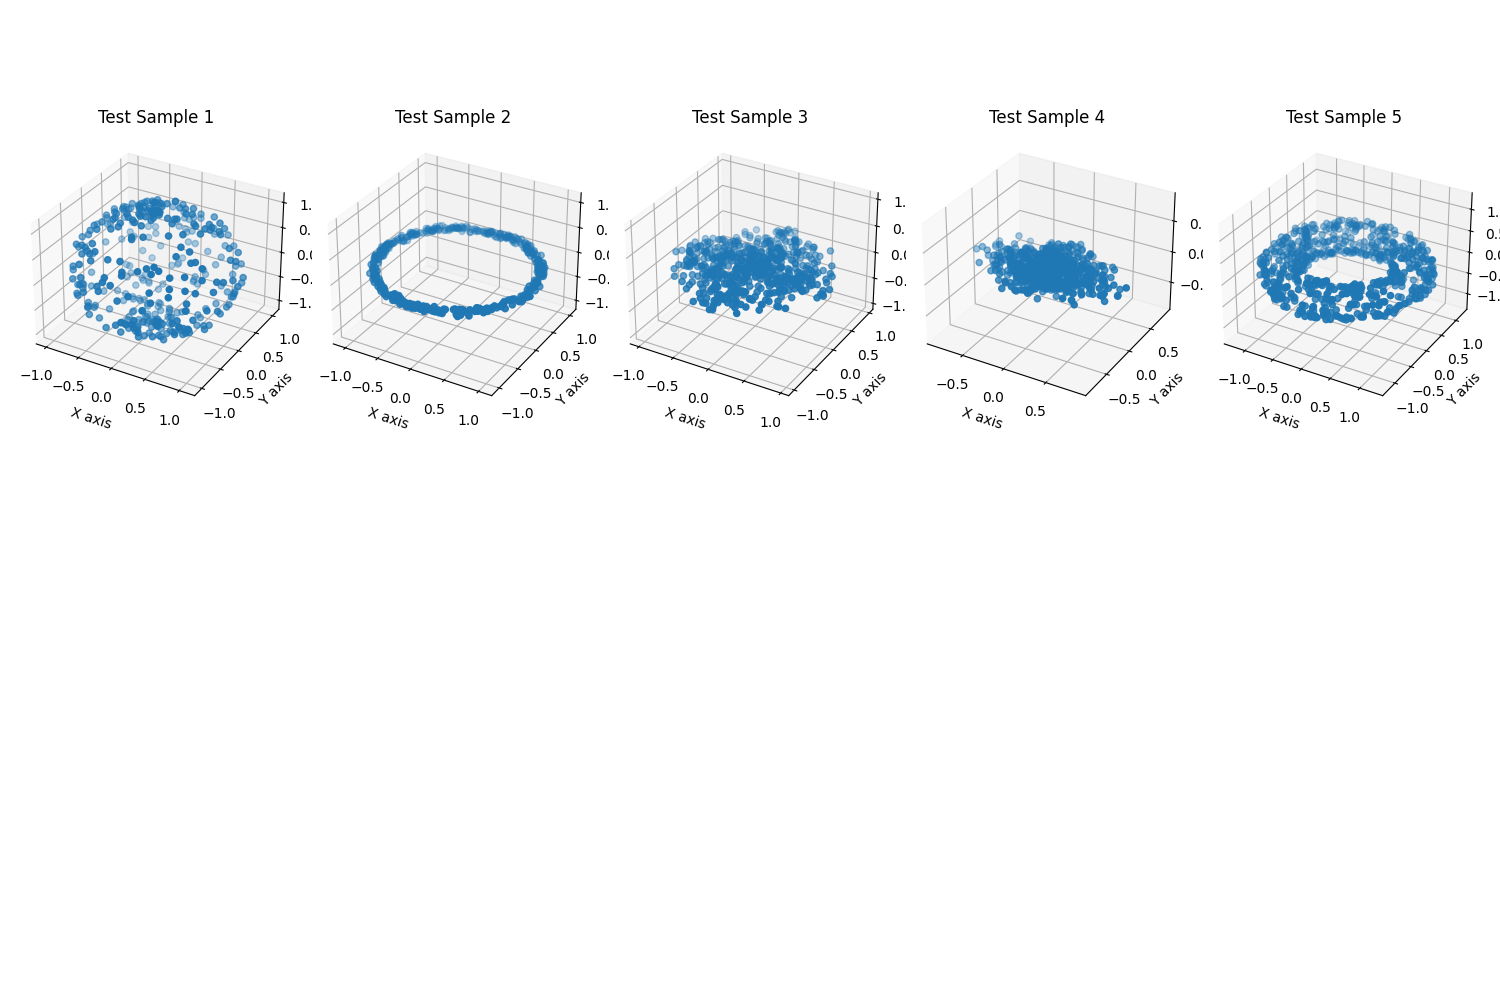

In [126]:
# Reverse the mapping from shape names to label numbers
label_names = {0: "sphere", 1: "circle", 2: "line_segment", 3: "torus", 4: "flat_disc", 5: "ellipsoid", 6: "perturbed_3_disc"}

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Visualize a few test samples, their predictions, and actual labels
num_samples_to_visualize = 5
fig = plt.figure(figsize=(15, 10))

for i in range(num_samples_to_visualize):
    # Get the original point cloud index from the test set
    original_index = idx_test[i]
    print(f"Looking for original index: {original_index}")

    # Find the test point cloud using the index
    test_point_cloud = next((pc for idx, pc, _ in original_shape_data if idx == original_index), None)

    if test_point_cloud is not None:
        # Plot the point cloud
        ax = fig.add_subplot(2, num_samples_to_visualize, i + 1, projection='3d')
        plot_point_cloud(test_point_cloud, ax, title=f"Test Sample {i+1}")

        # Set the same scale for all axes
        max_range = np.array([test_point_cloud[:,0].max()-test_point_cloud[:,0].min(), 
                              test_point_cloud[:,1].max()-test_point_cloud[:,1].min(), 
                              test_point_cloud[:,2].max()-test_point_cloud[:,2].min()]).max() / 2.0
        mid_x = (test_point_cloud[:,0].max()+test_point_cloud[:,0].min()) * 0.5
        mid_y = (test_point_cloud[:,1].max()+test_point_cloud[:,1].min()) * 0.5
        mid_z = (test_point_cloud[:,2].max()+test_point_cloud[:,2].min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        # Print the prediction and actual label
        predicted_label = y_pred[i]
        actual_label = y_test[i]
        predicted_shape = label_names.get(predicted_label, "Unknown")
        actual_shape = label_names.get(actual_label, "Unknown")
        print(f"Test Sample {i+1} - Predicted Class: {predicted_shape}, Actual Class: {actual_shape}")
    else:
        print(f"Test Sample {i+1} - Original point cloud not found for index {original_index}")

plt.tight_layout()
plt.show()


We can check which shapes were misclassified in test set.

In [127]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a mapping from label numbers to shape names (update based on your labels)
shape_names = {0: 'sphere', 1: 'circle', 2: 'line_segment', 3: 'torus', 4: 'flat_disc', 5: 'ellipsoid', 6: 'perturbed_3_disc'}

# Calculate and display class-wise accuracy
for class_index, class_name in shape_names.items():
    correct = conf_matrix[class_index, class_index]
    incorrect = sum(conf_matrix[class_index, :]) - correct
    print(f"Class '{class_name}': Correctly classified: {correct}, Incorrectly classified: {incorrect}")



Class 'sphere': Correctly classified: 9, Incorrectly classified: 0
Class 'circle': Correctly classified: 9, Incorrectly classified: 0
Class 'line_segment': Correctly classified: 9, Incorrectly classified: 0
Class 'torus': Correctly classified: 7, Incorrectly classified: 2
Class 'flat_disc': Correctly classified: 9, Incorrectly classified: 0
Class 'ellipsoid': Correctly classified: 9, Incorrectly classified: 0
Class 'perturbed_3_disc': Correctly classified: 9, Incorrectly classified: 0


In [128]:
def analyze_misclassifications(y_true, y_pred, label_names):
    misclassified = []

    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            original_class = label_names.get(y_true[i], "Unknown")
            predicted_class = label_names.get(y_pred[i], "Unknown")
            misclassified.append((i, original_class, predicted_class))

    return misclassified

# Reverse the mapping from shape names to label numbers
label_names = {0: "sphere", 1: "circle", 2: "line_segment", 3: "torus", 4: "flat_disc", 5: "ellipsoid", 6: "perturbed_3_disc"}

# Analyze misclassifications on the test set
misclassifications = analyze_misclassifications(y_test, y_pred, label_names)

# Print the misclassifications
print("Misclassified Shapes:")
for index, original_class, predicted_class in misclassifications:
    print(f"Index: {index}, Original Class: {original_class}, Predicted Class: {predicted_class}")


Misclassified Shapes:
Index: 59, Original Class: torus, Predicted Class: sphere
Index: 62, Original Class: torus, Predicted Class: sphere


### Analyzing predictions on training set

We can also check how our model is performing on training set to see if the same shapes are causing the trouble.

In [129]:
# Predict on the training set
y_train_pred = svm_model.predict(X_train)

# Calculate the confusion matrix for training data
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

# Create a mapping from label numbers to shape names (update based on your labels)
shape_names = {0: 'sphere', 1: 'circle', 2: 'line_segment', 3: 'torus', 4: 'flat_disc', 5: 'ellipsoid', 6: 'perturbed_3_disc'}

# Calculate and display class-wise accuracy for training data
for class_index, class_name in shape_names.items():
    correct_train = conf_matrix_train[class_index, class_index]
    incorrect_train = sum(conf_matrix_train[class_index, :]) - correct_train
    print(f"Training Data - Class '{class_name}': Correctly classified: {correct_train}, Incorrectly classified: {incorrect_train}")


Training Data - Class 'sphere': Correctly classified: 21, Incorrectly classified: 0
Training Data - Class 'circle': Correctly classified: 21, Incorrectly classified: 0
Training Data - Class 'line_segment': Correctly classified: 21, Incorrectly classified: 0
Training Data - Class 'torus': Correctly classified: 21, Incorrectly classified: 0
Training Data - Class 'flat_disc': Correctly classified: 21, Incorrectly classified: 0
Training Data - Class 'ellipsoid': Correctly classified: 21, Incorrectly classified: 0
Training Data - Class 'perturbed_3_disc': Correctly classified: 21, Incorrectly classified: 0


In [130]:
# Calculate accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Accuracy: {accuracy_train:.2f}")

Accuracy: 1.00


In [131]:
# Analyze misclassifications on the training set
train_misclassifications = analyze_misclassifications(y_train, y_train_pred, label_names)

# Print the misclassifications
print("Misclassified Shapes in Training Set:")
for index, original_class, predicted_class in train_misclassifications:
    print(f"Index: {index}, Original Class: {original_class}, Predicted Class: {predicted_class}")


Misclassified Shapes in Training Set:


[(77, 'torus', 'sphere'), (89, 'torus', 'sphere')]
Misclassified Sample 1 (Index: 77) - Original Class: torus, Predicted Class: sphere
Misclassified Sample 2 (Index: 89) - Original Class: torus, Predicted Class: sphere


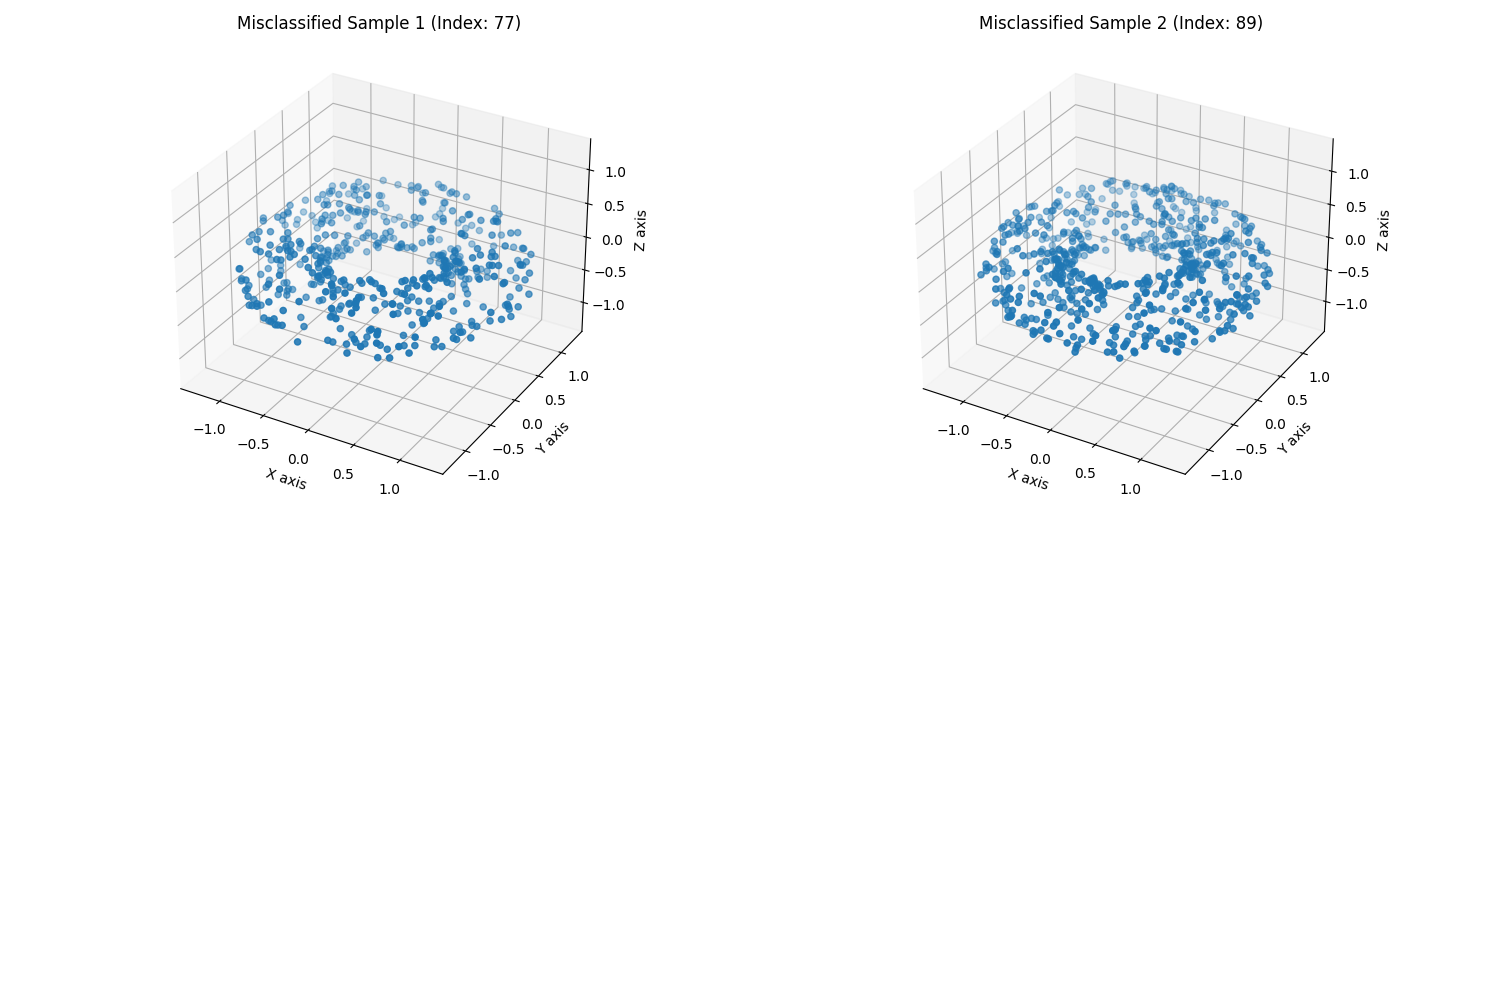

In [132]:
import matplotlib.pyplot as plt
import numpy as np

def plot_point_cloud(point_cloud, ax, title="Point Cloud"):
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
    ax.set_title(title)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Set the same scale for all axes
    max_range = np.array([point_cloud[:,0].max()-point_cloud[:,0].min(), 
                          point_cloud[:,1].max()-point_cloud[:,1].min(), 
                          point_cloud[:,2].max()-point_cloud[:,2].min()]).max() / 2.0
    mid_x = (point_cloud[:,0].max()+point_cloud[:,0].min()) * 0.5
    mid_y = (point_cloud[:,1].max()+point_cloud[:,1].min()) * 0.5
    mid_z = (point_cloud[:,2].max()+point_cloud[:,2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)


# Analyze misclassifications with test set index
def analyze_misclassifications(y_true, y_pred, label_names, idx_test):
    misclassified = []

    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            original_class = label_names.get(y_true[i], "Unknown")
            predicted_class = label_names.get(y_pred[i], "Unknown")
            test_set_index = idx_test[i]  # Test set index
            misclassified.append((test_set_index, original_class, predicted_class))

    return misclassified

# Assuming 'idx_test' is a list of indices from the test set in the original dataset
misclassifications = analyze_misclassifications(y_test, y_pred, label_names, idx_test)
print(misclassifications)

# Visualize misclassified shapes
fig = plt.figure(figsize=(15, 10))

for i, (test_set_index, original_class, predicted_class) in enumerate(misclassifications):
    # Find the original point cloud using the test set index
    test_point_cloud = next((pc for idx, pc, _ in original_shape_data if idx == test_set_index), None)

    if test_point_cloud is not None:
        # Plot the point cloud
        ax = fig.add_subplot(2, len(misclassifications), i + 1, projection='3d')
        plot_point_cloud(test_point_cloud, ax, title=f"Misclassified Sample {i+1} (Index: {test_set_index})")

        print(f"Misclassified Sample {i+1} (Index: {test_set_index}) - Original Class: {original_class}, Predicted Class: {predicted_class}")
    else: 
        print("Test set index not found in original data")

plt.tight_layout()
plt.show()



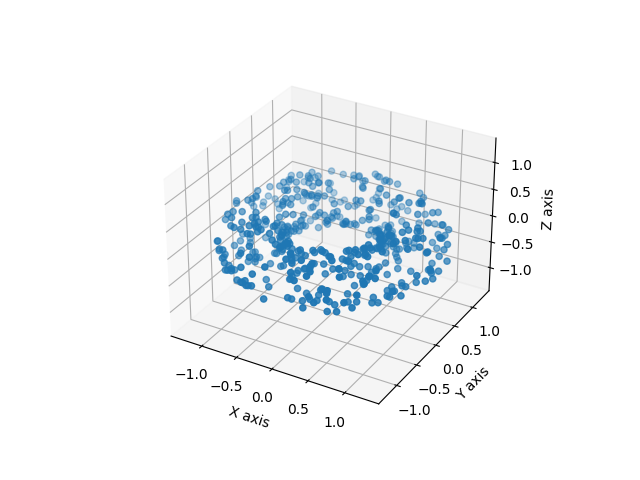

In [133]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import ipywidgets as widgets

def plot_interactive_point_cloud(index, shape_data):
    """
    Plots an interactive 3D point cloud for the given index from the shape data.

    Args:
    index (int): Index of the point cloud in the shape data.
    shape_data (list): List of tuples containing (index, point cloud, label).
    """
    point_cloud = next((pc for idx, pc, _ in shape_data if idx == index), None)

    if point_cloud is not None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
        
        # Setting the same scale for all axes
        max_range = np.array([point_cloud[:,0].max()-point_cloud[:,0].min(), 
                              point_cloud[:,1].max()-point_cloud[:,1].min(), 
                              point_cloud[:,2].max()-point_cloud[:,2].min()]).max() / 2.0
        mid_x = (point_cloud[:,0].max()+point_cloud[:,0].min()) * 0.5
        mid_y = (point_cloud[:,1].max()+point_cloud[:,1].min()) * 0.5
        mid_z = (point_cloud[:,2].max()+point_cloud[:,2].min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        plt.show()
    else:
        print("Index not found in the dataset")

# Example usage
plot_interactive_point_cloud(77, original_shape_data)  # Replace 5 with the index of the sample you want to visualize


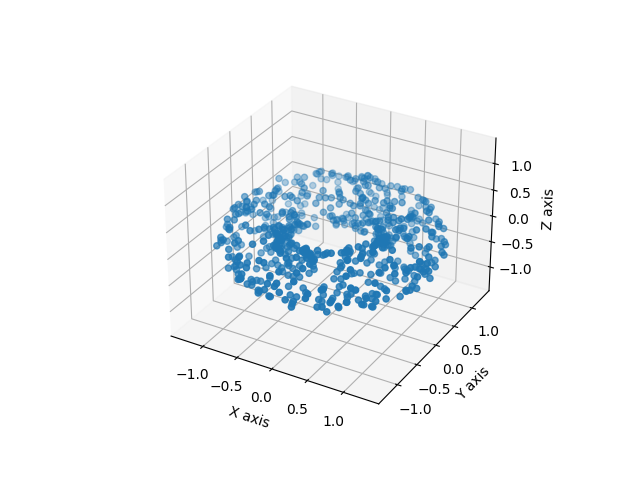

In [134]:
# Example usage
plot_interactive_point_cloud(89, original_shape_data)  # Replace 5 with the index of the sample you want to visualize

### Translations and rotations

In [135]:
# # random translation:
# from m_translate_rotate import translate, rotate
# import random
# from m_create_pointclouds import create_circle

# rand = 0.05
# t_vec = np.random.uniform(-10,10,3)
# # random rotation
# r_vec = np.random.uniform(-1,1,3)
# phi = random.random() * 2 * np.pi

# point_cloud=create_circle()

# rotated = rotate(point_cloud, r_vec, phi)
# translated = translate(rotated, t_vec)

# from standardize_ap import scale_and_center_point_cloud
# sc_point_cloud = scale_and_center_point_cloud(point_cloud=point_cloud,target_size=2)

# from remove_ball import remove_center_ball
# rem_ball_pc=remove_center_ball(sc_point_cloud,0.5)

# from create_PD_and_PI import process_shape
# fl_st_pc=process_shape((200,sc_point_cloud,1))
# fl_rembll_pc=process_shape((201,rem_ball_pc,1))

In [138]:
# Load the combined flattened images, labels, and original point clouds
with open('Data/TR_m_combined_flattened_data_with_indices.pkl', 'rb') as f_img:
#with open('Data/m_flattened_images_with_indices.pkl', 'rb') as f_img:
    TR_combined_flattened_data = pickle.load(f_img)

# Extracting indices, combined vectors, and labels
TR_indices, TR_combined_vectors, TR_labels = zip(*TR_combined_flattened_data)

# Convert to numpy arrays
TR_combined_vectors = np.array(TR_combined_vectors)
TR_labels = np.array(TR_labels)

# Load the original point clouds for visualization
with open('m_rotated_shapes_data.pkl', 'rb') as file:
    TR_original_shape_data = pickle.load(file)

# Extracting indices, combined vectors, and labels
TR_indices2, TR_combined_vectors2, TR_labels2 = zip(*TR_original_shape_data)

In [ ]:
TR_y_pred = svm_model.predict(TR_combined_vectors)

# Calculate accuracy
TR_accuracy = accuracy_score(TR_labels, TR_y_pred)
print(f"Accuracy: {TR_accuracy:.2f}")